In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import spectral_binaries as sb
from spectral_binaries.constants import NUM, SNR_BINS, SNR_CROSSOVER_TOL
warnings.filterwarnings("ignore")

In [50]:
df = pd.read_hdf(sb.DATA_FOLDER + "single_spectra_with_synthphot.h5", key="singles")
df = df.dropna(subset=["WAVEGRID"])

WAVEGRID = df["WAVEGRID"].iloc[0]

In [53]:
np.save(sb.DATA_FOLDER + "wavegrid.npy", WAVEGRID)

In [9]:
df_flux = pd.DataFrame(df["FLUX"].tolist()).add_prefix("flux_")
df_flux = df_flux.assign(spectral_type=df["SPT"])
df_flux = df_flux.assign(spectral_type=df_flux["spectral_type"].str[:4])
df_noise = pd.DataFrame(df["UNCERTAINTY"].tolist()).add_prefix("unc_")
df = pd.concat([df_flux, df_noise], axis=1)

In [10]:
df.head()

,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,unc_399,unc_400,unc_401,unc_402,unc_403,unc_404,unc_405,unc_406,unc_407,unc_408
0,1.672499e-08,1.655940e-08,1.658669e-08,1.682406e-08,1.708547e-08,1.713102e-08,1.671561e-08,1.648314e-08,1.633086e-08,1.632518e-08,...,6.896006e-12,6.747350e-12,6.545798e-12,6.372711e-12,6.386528e-12,6.375193e-12,6.491666e-12,6.550896e-12,6.489186e-12,6.482373e-12
1,1.632853e-08,1.630633e-08,1.636388e-08,1.651997e-08,1.649871e-08,1.627791e-08,1.616394e-08,1.611972e-08,1.610504e-08,1.616226e-08,...,2.816642e-12,2.876539e-12,2.978667e-12,2.994860e-12,2.864537e-12,2.769406e-12,2.701306e-12,2.671008e-12,2.663559e-12,2.656147e-12
2,1.655195e-08,1.675343e-08,1.703754e-08,1.701382e-08,1.709034e-08,1.697546e-08,1.690522e-08,1.690822e-08,1.680053e-08,1.677852e-08,...,2.911525e-11,2.528184e-11,2.410808e-11,2.349843e-11,2.346956e-11,2.305766e-11,2.251533e-11,2.331378e-11,2.229647e-11,2.210986e-11
3,1.692575e-08,1.673746e-08,1.681820e-08,1.700432e-08,1.729889e-08,1.756854e-08,1.765144e-08,1.752056e-08,1.715138e-08,1.686506e-08,...,5.445626e-12,5.063282e-12,4.855634e-12,4.874336e-12,4.713995e-12,4.719818e-12,4.780033e-12,4.829315e-12,4.879436e-12,4.817640e-12
4,9.366333e-09,9.309978e-09,9.454448e-09,9.625293e-09,9.813402e-09,9.900985e-09,9.837614e-09,9.728143e-09,1.005449e-08,9.949374e-09,...,1.102293e-10,8.194994e-11,8.459571e-11,9.686215e-11,1.070134e-10,5.313086e-11,1.190048e-11,3.619160e-11,4.776696e-11,4.774044e-11


In [11]:
df["spectral_type"].value_counts()

M8.0    257
L1.0    225
L7.0    174
L2.0    147
M9.0    109
L6.0    109
L0.0     95
M7.0     87
T0.0     68
M6.0     59
T1.0     54
L5.0     53
L4.0     47
L9.0     47
L3.0     46
M5.0     40
T5.0     39
T6.0     36
T7.0     31
M4.0     29
M3.0     23
T3.0     23
L8.0     22
T2.0     21
T4.0     16
M1.0     14
T8.0     13
M0.0      4
T9.0      3
M2.0      2
Name: spectral_type, dtype: int64

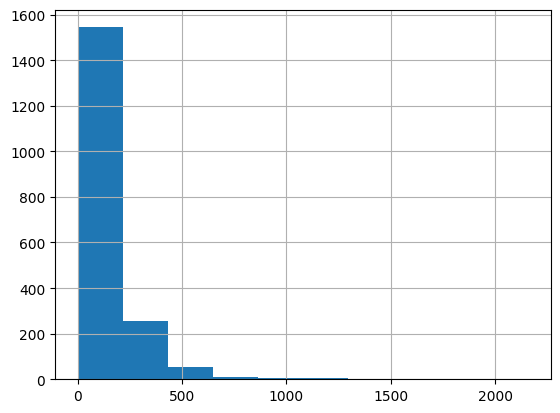

In [13]:
df = df.assign(
    snr=df.apply(
        lambda x: sb.measureSN(
            WAVEGRID,
            x.filter(like="flux").values.astype(float),
            x.filter(like="unc").values.astype(float),
        ),
        axis=1,
    )
)
df["snr"].hist();

In [30]:
# Bins: [0,10], [10, 25], [25, 50], ..., [100, max]

# Start from highest 150+ <- select all sources >= 150 SNR
# Vary it such that in range [150, original SNR]
# Then [100, max] SNR stars <- resample such that SNR is [100 to 150]
# Then [50, max] <- resample from all of these such that SNR is [50 to 100]


# Start at highest bin, copy with no change/duplicate
# If there is a lot of different variation in the lower SNR bins, maybe down-sample to reach level of representation of the higher bin
def bin_snr(_df, snr_col):
    _bins = [0, 10, 25, 50, 75, 100, 150, 200, 10000]
    _df[f"{snr_col}_bins"] = pd.cut(_df[snr_col], _bins)
    return _df


def get_new_scale(
    wave, _flux, _unc, lower, upper, bin_tol, _rng=[1.2, 1.35], verbose=0
):
    if verbose > 0:
        print(f"SNR lower bound: {lower}, SNR upper bound: {upper}")
    lower = lower + bin_tol
    upper = upper - bin_tol
    if upper - lower < 1:
        upper = lower + 1
    desired_snr = np.random.randint(lower, upper, 1)[0]
    _idx = np.where((wave <= _rng[1]) & (wave >= _rng[0]))
    _scale = np.nanmedian(_flux[_idx] / (desired_snr * _unc[_idx]))
    return desired_snr, _scale


def target_snr(selected_stars, _lower_bound, _upper_bound, bin_tol, num_oversample):
    results = []
    for _ in range(num_oversample):
        for i, row in selected_stars.iterrows():
            _upper_bound = min(_upper_bound, row["snr"])
            flux_row = row.filter(like="flux").values.astype(float)
            unc_row = row.filter(like="unc").values.astype(float)
            _target_snr, new_scale = get_new_scale(
                WAVEGRID, flux_row, unc_row, _lower_bound, _upper_bound, bin_tol
            )
            new_flux, new_unc = sb.addNoise(flux_row, unc_row, new_scale)
            final_snr = sb.measureSN(WAVEGRID, new_flux, new_unc)
            res = {
                "flux": new_flux,
                "unc": new_unc,
                "original_snr": row["snr"],
                "target_snr": _target_snr,
                "noise_scale": new_scale,
                "final_snr": final_snr,
            }
            results.append(res)
    res_df = pd.DataFrame(results)
    res_df = bin_snr(res_df, "final_snr")
    return res_df


def oversample_spectral_type(star_df, spectral_type):
    spectral_type_df = star_df.query(f"spectral_type == '{spectral_type}'")
    spectral_type_df = bin_snr(spectral_type_df, "snr")
    spectral_type_over = []
    for b in tqdm(SNR_BINS):
        if b == pd.Interval(0, 10):
            bin_tol = 1
        else:
            bin_tol = 5
        lower_bound, upper_bound = b.left, b.right
        stars_select = spectral_type_df.query(f"snr > {lower_bound}")
        if len(stars_select) == 0:
            stars_select = spectral_type_df.query(
                f"snr == {spectral_type_df['snr'].max()}"
            )
        bin_df = target_snr(
            stars_select,
            lower_bound,
            upper_bound,
            bin_tol,
            ((NUM + SNR_CROSSOVER_TOL) // len(stars_select)) + 1,
        )
        bin_df = bin_df.assign(
            final_target_diff=(bin_df["final_snr"] - bin_df["target_snr"])
            .diff()
            .abs()
        ).reset_index(drop=True)
        bin_df = bin_df.sort_values(by="final_target_diff").iloc[:NUM]
        spectral_type_over.append(bin_df)

    spectral_type_over = pd.concat(spectral_type_over)
    spectral_type_over = spectral_type_over.assign(spectral_type=spectral_type)
    return spectral_type_over


types = df["spectral_type"].unique()
oversampled = []

for t in types:
    print(f"Oversampling {t}...")
    over_spectral_df = oversample_spectral_type(df, t)
    oversampled.append(over_spectral_df)

oversampled = pd.concat(oversampled)

Oversampling M0.0...


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Oversampling M1.0...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Oversampling M2.0...


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Oversampling M3.0...


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Oversampling M4.0...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Oversampling M5.0...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Oversampling M6.0...


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Oversampling M7.0...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Oversampling M8.0...


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Oversampling M9.0...


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Oversampling L0.0...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Oversampling L1.0...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Oversampling L2.0...


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Oversampling L3.0...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Oversampling L4.0...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Oversampling L5.0...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Oversampling L6.0...


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Oversampling L7.0...


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Oversampling L8.0...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Oversampling L9.0...


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Oversampling T0.0...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Oversampling T1.0...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Oversampling T2.0...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Oversampling T3.0...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Oversampling T4.0...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Oversampling T5.0...


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Oversampling T6.0...


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Oversampling T7.0...


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Oversampling T8.0...


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Oversampling T9.0...


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


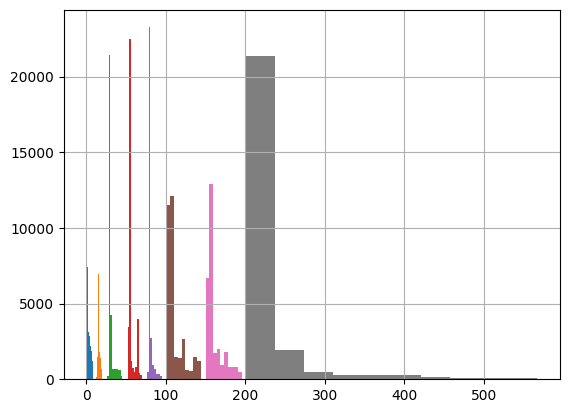

In [31]:
oversampled.groupby("final_snr_bins")["final_snr"].hist();spectral_type

In [33]:
oversampled = oversampled.groupby(["spectral_type", "final_snr_bins"]).head(NUM)

In [34]:
oversampled.groupby(["spectral_type", "final_snr_bins"]).size()

spectral_type  final_snr_bins
L0.0           (0, 10]           1000
               (10, 25]          1000
               (25, 50]          1000
               (50, 75]          1000
               (75, 100]         1000
                                 ... 
T9.0           (50, 75]          1000
               (75, 100]            0
               (100, 150]           0
               (150, 200]           0
               (200, 10000]         0
Length: 240, dtype: int64

In [42]:
over_flux = pd.DataFrame(oversampled["flux"].tolist()).add_prefix("flux_")
over_unc = pd.DataFrame(oversampled["unc"].tolist()).add_prefix("unc_")
oversampled_df = pd.concat([over_flux, over_unc], axis=1)

In [45]:
oversampled_df = oversampled_df.reset_index(drop=True)
oversampled = oversampled.reset_index(drop=True)
oversampled_df[["snr", "snr_bin", "spectral_type"]] = oversampled[["final_snr", "final_snr_bins", "spectral_type"]]

In [47]:
oversampled_df.head()

,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,unc_402,unc_403,unc_404,unc_405,unc_406,unc_407,unc_408,snr,snr_bin,spectral_type
0,1.659091e-08,1.673770e-08,1.697480e-08,1.704410e-08,1.707763e-08,1.688355e-08,1.676833e-08,1.682165e-08,1.683034e-08,1.683412e-08,...,4.621796e-11,4.616120e-11,4.535105e-11,4.428435e-11,4.585478e-11,4.385389e-11,4.348686e-11,289.482110,"(200, 10000]",M0.0
1,1.638842e-08,1.695836e-08,1.706520e-08,1.705089e-08,1.713664e-08,1.692533e-08,1.693817e-08,1.683467e-08,1.681457e-08,1.669283e-08,...,6.404489e-11,6.396623e-11,6.284359e-11,6.136546e-11,6.354163e-11,6.076896e-11,6.026036e-11,209.361706,"(200, 10000]",M0.0
2,1.650934e-08,1.666313e-08,1.695188e-08,1.696640e-08,1.692128e-08,1.720500e-08,1.688048e-08,1.692756e-08,1.706618e-08,1.673135e-08,...,5.467247e-11,5.460532e-11,5.364697e-11,5.238514e-11,5.424285e-11,5.187594e-11,5.144177e-11,244.854805,"(200, 10000]",M0.0
3,1.688669e-08,1.681928e-08,1.673371e-08,1.696475e-08,1.741652e-08,1.760156e-08,1.756067e-08,1.755815e-08,1.713051e-08,1.692617e-08,...,2.240217e-11,2.166525e-11,2.169201e-11,2.196876e-11,2.219525e-11,2.242561e-11,2.214160e-11,277.044679,"(200, 10000]",M0.0
4,1.637496e-08,1.617614e-08,1.636264e-08,1.649530e-08,1.645160e-08,1.625775e-08,1.617550e-08,1.612956e-08,1.616505e-08,1.617210e-08,...,1.130100e-11,1.080923e-11,1.045025e-11,1.019328e-11,1.007895e-11,1.005085e-11,1.002288e-11,420.362585,"(200, 10000]",M0.0


In [59]:
oversampled_df = oversampled_df.assign(snr_bin=oversampled_df["snr_bin"].astype(str))

In [60]:
oversampled_df.to_hdf(sb.DATA_FOLDER + "singles_oversampled_04_05.h5", key="singles")

In [61]:
oversampled_df.dtypes

flux_0           float64
flux_1           float64
flux_2           float64
flux_3           float64
flux_4           float64
                  ...   
unc_407          float64
unc_408          float64
snr              float64
snr_bin           object
spectral_type     object
Length: 821, dtype: object